3. Do a bit of research on similar problems such as named entity recognition, find a dataset, train a model, and report your results.

In [1]:
# https://towardsdatascience.com/named-entity-recognition-ner-using-keras-bidirectional-lstm-28cd3f301f54
import pandas as pd
data = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [3]:
from itertools import chain
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word'].to_list()))
    else:
        vocab = list(set(data['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')

data['Word_idx'] = data['Word'].map(token2idx)
data['Tag_idx'] = data['Tag'].map(tag2idx)
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,21263,11
1,NaN,of,IN,O,34238,11
2,NaN,demonstrators,NNS,O,34916,11
3,NaN,have,VBP,O,13009,11
4,NaN,marched,VBN,O,12529,11


In [4]:
# Fill na
data_fillna = data.fillna(method='ffill', axis=0)
# Groupby and collect columns
data_group = data_fillna.groupby(
['Sentence #'],as_index=False
)['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))
# Visualise data
data_group.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[21263, 34238, 34916, 13009, 12529, 4047, 4395...","[11, 11, 11, 11, 11, 11, 12, 11, 11, 11, 11, 1..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[27941, 15208, 28023, 25849, 12990, 33883, 449...","[0, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[26827, 33571, 29102, 13396, 21324, 33749, 335...","[11, 11, 9, 11, 11, 11, 11, 11, 12, 11, 11, 11..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[29591, 28218, 16436, 23864, 18898, 29392, 122...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[22003, 1786, 743, 34075, 9000, 189, 34978, 33...","[12, 11, 11, 10, 1, 11, 9, 11, 12, 11, 0, 11, ..."


In [18]:
!pip3 install tensorflow

    100% |████████████████████████████████| 109.2MB 19kB/s 
    100% |████████████████████████████████| 491kB 1.4MB/s 
    100% |████████████████████████████████| 51kB 1.7MB/s 
    100% |████████████████████████████████| 51kB 1.2MB/s 
    100% |████████████████████████████████| 61kB 925kB/s 
  Running setup.py bdist_wheel for wrapt ... done
  Stored in directory: /root/.cache/pip/wheels/b1/c2/ed/d62208260edbd3fa7156545c00ef966f45f2063d0a84f8208a
  Running setup.py bdist_wheel for termcolor ... done
  Stored in directory: /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
Successfully built wrapt termcolor


In [19]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

def get_pad_train_test_val(data_group, data):

    #get max token and tag length
    n_token = len(list(set(data['Word'].to_list())))
    n_tag = len(list(set(data['Tag'].to_list())))

    #Pad tokens (X var)    
    tokens = data_group['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tokens length:', len(train_tokens),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(data_group, data)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [1]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        # A bit more efficient than normal Softmax
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # print(input.shape, hidden.shape)
        combined = torch.cat((input, hidden), 1)
        a = self.i2h(combined)
        hidden = torch.tanh(a)
        o = self.h2o(hidden)
        y_hat = self.softmax(o)
        # hidden = self.i2h(combined)
        # output = self.i2o(combined)
        # output = self.softmax(output)
        return y_hat, hidden

    def initHidden(self, batch_size = 1):
        return torch.zeros(batch_size, self.hidden_size)

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch


# Util Functions
def findFiles(path):
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def letterToIndex(letter):
    return all_letters.find(letter)

# (For demonstration) turn a letter into a <1 x n_letters> tensor

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> tensor
# (an array of one-hot letter vectors)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i




# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


# Prepare Data
all_letters = string.ascii_letters + " .,;'"

category_lines = {}
all_categories = []

n_letters = len(all_letters)

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines


n_categories = len(all_categories)

# n_hidden = 128
# rnn = RNN(n_letters, n_hidden, n_categories)

In [3]:
# https://www.marktechpost.com/2020/04/12/implementing-batching-for-seq2seq-models-in-pytorch/
def batched_lines(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

def print_char(name_reps):
    # name_reps = name_reps.view((-1, name_reps.size()[-1]))
    # print(name_reps)
    for t in name_reps: 
        # if torch.sum(t) == 0:
        #     print('')
        # else:
            index = t.argmax()
            print(all_letters[index])

def batched_categories(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = all_categories.index(lang)
    return rep

In [4]:
out = batched_lines(['Shyam','Ram'],9)
print(out.shape)

print_char(out[:,0,:])
print()
print_char(out[:,1,:])

torch.Size([9, 2, 57])
S
h
y
a
m
'
'
'
'

R
a
m
'
'
'
'
'
'


In [5]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn = rnn.to('cuda:1')

import random

def randomChoice(l):
    # random.randint range is inclusive thus len(l)-1
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(batch_size = 1):
    if(batch_size == 1):
        category = randomChoice(all_categories)
        line = randomChoice(category_lines[category])
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
        line_tensor = lineToTensor(line)
        return category, line, category_tensor, line_tensor
    else:
        max_length = 0
        categories = []
        lines = []
        lines_length = []
        for i in range(batch_size):
            category = randomChoice(all_categories)
            line = randomChoice(category_lines[category])
            categories.append(category)
            lines.append(line)
            lines_length.append(len(line))
            if(len(line) > max_length): max_length = len(line)
        line_tensor = batched_lines(lines,max_length)
        category_tensor = batched_categories(categories)
        # padded_line_tensor = torch.nn.utils.rnn.pack_padded_sequence(line_tensor, lines_length, enforce_sorted = False)
        return categories, lines, category_tensor, line_tensor

# for i in range(10):
# category, line, category_tensor, line_tensor = randomTrainingExample(10, 'cuda:1')
# print(category_tensor.shape, line_tensor.shape)
#     print('category =', category, '/ line =', line)

# If use softmax -> corss entropy
# If use logsoftmax -> negative log likelihood loss
criterion = nn.NLLLoss()

In [6]:
# input = letterToTensor('B').to('cuda:1')
# hidden = torch.zeros(1, n_hidden).to('cuda:1')
# print(input)
# output, next_hidden = rnn(input, hidden)
# output

In [7]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden(line_tensor.shape[1]).to('cuda:1')

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [8]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()
rnn = rnn.to('cuda:1')

batch_size = 10
# n_iters = int(n_iters / batch_size)
# print_every = int(print_every / batch_size)
# plot_every = int(plot_every / batch_size)

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample(batch_size)
    # print(type(category_tensor.to('cuda:1')), type(line_tensor))

    output, loss = train(category_tensor.to('cuda:1'), line_tensor.to('cuda:1'))
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 13s) 2.8822 ['Bekyros', 'Turiyansky', 'Mackay', 'Sokolofsky', 'Bear', 'Murtas', 'Hayami', 'Haanrade', 'Tian', 'Haddad'] / Japanese ✗ (['Greek', 'Russian', 'Scottish', 'Polish', 'English', 'Italian', 'Japanese', 'Dutch', 'Chinese', 'Arabic'])
10000 10% (0m 26s) 2.4625 ['Abbascia', 'Sauvage', 'Janowski', 'Matjeka', 'Almeida', 'Jiao', 'Ha', 'Tracey', 'Henriques', 'Perez'] / Greek ✗ (['Italian', 'French', 'Polish', 'Czech', 'Portuguese', 'Chinese', 'Vietnamese', 'Irish', 'Portuguese', 'Spanish'])
15000 15% (0m 39s) 2.4675 ['Adam', 'Kassab', 'Lobo', 'Brzezicki', 'Monahan', 'Freitas', 'Rodrigues', 'Urbina', 'Tzekhmistrenko', 'Delgado'] / Japanese ✗ (['French', 'Arabic', 'Portuguese', 'Polish', 'Irish', 'Portuguese', 'Portuguese', 'Spanish', 'Russian', 'Spanish'])
20000 20% (0m 52s) 2.0142 ['Nanami', 'Nasato', 'Espino', 'Yamato', 'Gorski', 'Flynn', 'Kohl', 'Laurent', 'Ta', 'Zimin'] / Japanese ✗ (['Japanese', 'Italian', 'Spanish', 'Japanese', 'Polish', 'Irish', 'German', 'French', 

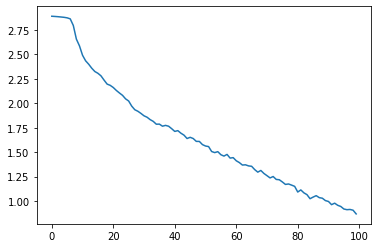

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


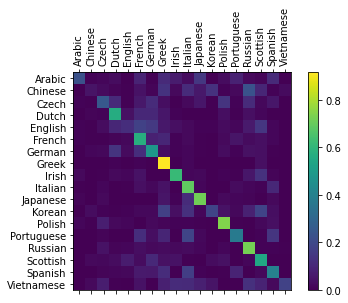

In [10]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden().to('cuda:1')

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor.to('cuda:1'))
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [12]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line).to('cuda:1'))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.99) Russian
(-1.40) English
(-2.27) Irish

> Jackson
(-0.21) Scottish
(-2.37) English
(-3.13) Russian

> Satoshi
(-1.04) Japanese
(-1.39) Polish
(-1.44) Italian
